## ●Notebookの内容

前処理&形状変換後データ(コード5の「変数選択後の前処理&形状変換」で作成したもの)の読み込みと左右の入れ込みデータの時点ずらし、モデルの学習、学習損失lossとアウトオブサンプルテスト損失lossの可視化と保存

# 1. 前準備

## 1.1 パッケージのインポート・乱数固定

In [1]:
import pandas as pd #pandasパッケージをインポート
import numpy as np #numpyパッケージをインポート
import torch #ライブラリ「PyTorch」のtorchパッケージをインポート
import torch.nn as nn #「ニューラルネットワーク」モジュールの別名定義
import torch.nn.functional as F #「ニューラルネットワーク・活性化関数」モジュールの別名定義
import collections
import os
import pickle
import optuna
import torch.optim as optim

#乱数の固定
torch.manual_seed(123)

## 1.2 MPSの使用指定

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
print('MPSの使用は',torch.backends.mps.is_available(),'である(Trueなら使用可能、Falseなら使用不可)。')

MPSの使用は True である(Trueなら使用可能、Falseなら使用不可)。


# 2. モデルパラメータ数算出関数の定義

In [3]:
from prettytable import PrettyTable

def count_parameters2(model):
    table = PrettyTable(['Modules', 'Parameters'])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    #print(table)
    #print(f'Total Trainable Params: {total_params}')
    return total_params

# 3. 整理後データの読み込みと時点ずらし作業
財務データ：1994/12〜2021/11

配当込み収益率：1995/01〜2021/12

In [4]:
pickle_in = open("./inright_data.pickle","rb") #ファイルの読み込み, 配当込み収益率はランク正規化をしていないデータであることに注意
pickle_in_2 = open("./inleft_data.pickle","rb") #ファイルの読み込み
pickle_in_3 = open("./ranked_data.pickle","rb") #ファイルの読み込み
returns_data_4_0 = pickle.load(pickle_in)
returns_data_4 = returns_data_4_0.iloc[1:,0:].reset_index().iloc[:,1:] #1995/1~2021/12のデータを抽出
data_5_11_0 = pickle.load(pickle_in_2)
data_5_11 = data_5_11_0.iloc[:324,0:].reset_index().iloc[:,1:] #1994/12~2021/11のデータを抽出
data_5_7_0 = pickle.load(pickle_in_3)
data_5_7_1 = data_5_7_0.query('期日.str.contains("1994")', engine='python') #1994のデータを抽出
data_5_7_2 = data_5_7_1.index.values.tolist() #1994/12のデータのindexをlist型に変更
data_5_7 = data_5_7_0[~data_5_7_0.index.isin(data_5_7_2)] #1994/12のデータのindexにあうものを削除
pickle_in.close()
pickle_in_2.close()
pickle_in_3.close()
#display(returns_data_4), display(data_5_11), display(data_5_7)

In [5]:
day_num_5 = data_5_7.期日.nunique(dropna = True) #期日の数(月数)
com_num_5 = data_5_7.shape[0]/day_num_5 #分析可能な企業数
chara_num = data_5_11.shape[1]/int(com_num_5) #用いる企業特性の数
print('分析対象データの月数は',day_num_5,'、', '企業数は',com_num_5,'、', '企業特性数は',chara_num,'である。')

分析対象データの月数は 324 、 企業数は 1141.0 、 企業特性数は 40.0 である。


# 4. 入力データの準備

In [6]:
#右側ファクターネットワークの入力データ
x = returns_data_4.to_numpy()
#左側ベータネットワークの入力データ
y = data_5_11.iloc[:,0:].to_numpy()
x_2 = torch.tensor(x, dtype=torch.float32)
y_2 = torch.tensor(y, dtype=torch.float32)
print('右側ファクターネットワークの入力データの形状は',x.shape,'、', '左側ベータネットワークの入力データの形状は',y.shape,'である。')

右側ファクターネットワークの入力データの形状は (324, 1141) 、 左側ベータネットワークの入力データの形状は (324, 45640) である。


# 5. オートエンコーダークラスの生成

## 5.1 CA$_{1}$アーキテクチャ(左側に第1層を追加)

In [7]:
class Factors(nn.Module):
    def __init__(self):
        super(Factors, self).__init__()
        
        #層(layer：レイヤー)を定義
        
        ##右側(ファクターネットワーク)の層
        self.fc_r1 = nn.Linear( 
            N*1, #データ(特徴)の入力ユニット数(1059銘柄*1)
            K*1) #出力ユニット数(5ファクター*1)

        ##左側(ベータネットワーク)の層
        self.fc_l1 = nn.Linear(
            N*P, #データ(特徴)の入力ユニット数(1059銘柄*85企業特性)
            lhidden) #出力ユニット数(32)
        
        self.fc_l2 = nn.Linear(
            lhidden, #入力ユニット数(32)
            N*K) #出力結果への出力ユニット数(1059銘柄*5ファクター)
        
    def forward(self, x, y):
        # フォワードパスを定義
        
        #右側(ファクターネットワーク)のフォワードパスを定義
        x = (self.fc_r1(x))
        
        #左側(ベータネットワーク)のフォワードパスを定義
        y = F.relu(self.fc_l1(y)) #ReLU関数を適用
        y = F.relu(self.fc_l2(y)) #ReLU関数を適用
        
        #サイズ自動調整
        y = y.view(K, N) #サイズ自動調整
        x = x.view(1, K) #サイズ自動調整
        
        return x, y #返り値

#NNの初期値
N = int(com_num_5) #銘柄数(1059銘柄)
P = int(chara_num)   #企業特性数(85特性)
K = 5    #ファクター数
lhidden = 32  #左側隠れ層1での圧縮次元数

#モデル（Factorsクラス）のインスタンス化
model = Factors()

model = model.to(device)

print(model) #モデルの内容を出力

Factors(
  (fc_r1): Linear(in_features=1141, out_features=5, bias=True)
  (fc_l1): Linear(in_features=45640, out_features=32, bias=True)
  (fc_l2): Linear(in_features=32, out_features=5705, bias=True)
)


In [8]:
from prettytable import PrettyTable

def count_parameters2(model):
    table = PrettyTable(['Modules', 'Parameters'])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    #print(table)
    #print(f'Total Trainable Params: {total_params}')
    return total_params
count_parameters2(model)

1654487

## 5.2 CA$_{1}$アーキテクチャ(左側に第1層を追加、P×1圧縮あり)

In [9]:
class Factors(nn.Module):
    def __init__(self):
        super(Factors, self).__init__()
        
        #層(layer：レイヤー)を定義
        
        ##右側(ファクターネットワーク)の層
        self.fc_r1 = nn.Linear( 
            N*1, #データ(特徴)の入力ユニット数(1059銘柄*1)
            P*1) #出力ユニット数(93企業特性*1)
        
        self.fc_r2 = nn.Linear( 
            P*1, #データ(特徴)の入力ユニット数(85企業特性*1)
            K*1) #出力ユニット数(5ファクター*1)

        ##左側(ベータネットワーク)の層
        self.fc_l1 = nn.Linear(
            N*P, #データ(特徴)の入力ユニット数(1059銘柄*85企業特性)
            lhidden) #出力ユニット数(32)
        
        self.fc_l2 = nn.Linear(
            lhidden, #入力ユニット数(32)
            N*K) #出力結果への出力ユニット数(1059銘柄*5ファクター)
        
    def forward(self, x, y):
        # フォワードパスを定義
        
        #右側(ファクターネットワーク)のフォワードパスを定義
        x = (self.fc_r1(x))
        x = (self.fc_r2(x))
        
        #左側(ベータネットワーク)のフォワードパスを定義
        
        y = F.relu(self.fc_l1(y)) #ReLU関数を適用
        y = F.relu(self.fc_l2(y)) #ReLU関数を適用
        
        #サイズ自動調整
        
        y = y.view(K, N) #サイズ自動調整
        x = x.view(1, K) #サイズ自動調整
        
        return x, y #返り値

#NNの初期値
N = int(com_num_5) #銘柄数(1059銘柄)
P = int(chara_num)   #企業特性数(85特性)
K = 5    #ファクター数
lhidden = 32  #左側隠れ層1での圧縮次元数

#モデル（Factorsクラス）のインスタンス化
model = Factors()

model = model.to(device)

print(model) #モデルの内容を出力

Factors(
  (fc_r1): Linear(in_features=1141, out_features=40, bias=True)
  (fc_r2): Linear(in_features=40, out_features=5, bias=True)
  (fc_l1): Linear(in_features=45640, out_features=32, bias=True)
  (fc_l2): Linear(in_features=32, out_features=5705, bias=True)
)


# 6. 学習&アウトオブサンプルテスト

## 6.1 学習&アウトオブサンプルテスト関数の定義

In [10]:
num_workers = 1
num_month   = 1
x_batch = num_month
y_batch = num_month
criterion = nn.MSELoss()
count_max = 18 #学習に使っている年数
loss_list = []

#学習の関数
def train(model, optimizer, alpha, device):
    model.train()
    for i_year in range(18):
    #for i_year in range(4):
        count = 0
        xtrain_loader = torch.utils.data.DataLoader(x_2[:((i_year+1)*12),:], batch_size=x_batch, num_workers=num_workers, shuffle=False, pin_memory=True)
        ytrain_loader = torch.utils.data.DataLoader(y_2[:((i_year+1)*12),:], batch_size=y_batch, num_workers=num_workers, shuffle=False, pin_memory=True)
        for x_input, y_input in zip(xtrain_loader, ytrain_loader):
            count += 1
            x_input = x_input.to(device)
            y_input = y_input.to(device)
            u ,v = model(x_input.float(), y_input.float()) #モデルの出力を取得(左側出力v、右側出力uとする)
            uv = torch.mm(u, v) #最終的に積をとる
            loss = criterion(uv, x_input.float()) #入力x.float()と復元outputsの誤差を取得
            
            # パラメータのL1ノルムを損失関数に足す
            #l1 = sum(torch.norm(w , 1) for w in model.parameters()) #リスト内包表記
            l1 = sum(torch.norm(w/count_parameters2(model) , 1)  for w in model.parameters()) #リスト内包表記
            #loss = loss + alpha*l1.clone().detach()
            #loss = loss + alpha*l1.detach().clone()
            loss = loss + alpha*l1.detach()
            
            #print(loss.item())
            
            if count == count_max*12:
                print('最終的な学習loss', loss.item())
                loss_list.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #print(loss.item())

def OOStest(model, device):
    model.eval()
    OOS_loss = 0
    Numer_t = 0 #total R2の分子
    Numer_p = 0 #pred R2の分子
    Denom = 0 #total R2とpred R2の分母
    t = torch.tensor(0) #時刻
    u = torch.zeros(1,K)
    u_2 = torch.zeros(1,K)
    v = torch.zeros(K,N)
    u = u.to(device)
    u_2 = u_2.to(device)
    v = v.to(device)
    criterion2 = nn.MSELoss(reduction = 'sum') #total R2とpred R2の分子の計算を行うためのMSE
    
    with torch.no_grad():
        for x_input, y_input in zip(xOOS_loader, yOOS_loader):
            t += 1 #いわゆるt
            x_input = x_input.to(device)
            y_input = y_input.to(device)  
            u ,v = model(x_input.float(), y_input.float()) #モデルの出力を取得(左側出力v、右側出力uとする)
            uv = torch.mm(u, v) #最終的に積をとる
            
            loss = criterion(uv, x_input.float()) #入力x.float()と復元outputsの誤差を取得
            OOS_loss += loss.item()  # 誤差(損失)の更新
            
            #pred R2の分子の算出の準備
            u_2 += u
            u_3 = u_2 - u
            
            if t > 1: #tが2以上ならば
                #total R2の分子の算出
                Numer_t += criterion2(x_input.float(), uv).item() #total R2の分子(r_{t} - β_{t-1}f_{t})^2の和
                
                #pred R2の分子の算出
                lamb_t_1 = u_3/(t-1)
                uv_2 = torch.mm(lamb_t_1, v) #積
                Numer_p += criterion2(x_input.float(), uv_2).item() #pred R2の分子の算出のための計算(β_{t-1}λ_{t-1})の和

                #total R2とpred R2の分母の算出
                Denom += torch.sum(torch.square(x_input.float())).item() #total R2とpred R2の分母

                        
        OOS_loss = OOS_loss/len(xOOS_loader) #誤差の算出
        R_total = 1 - (Numer_t/Denom) #total R2の算出
        R_pred = 1 - (Numer_p/Denom) #pred R2の算出
    return OOS_loss, R_total, R_pred


## 6.2 最適化関数の定義

In [11]:
#最適化関数(specify loss function)をAdamに設定
def get_optimizer(model):
    adam_lr = 1e-5
    optimizer = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=0) #weight_decayは0
    return optimizer

## 6.3 学習&アウトオブサンプルテストの実行

In [12]:
# エポック数
n_epochs = 5
optimizer = get_optimizer(model)
alpha = 1e-5

i_year_3 = 5

xOOS_loader = torch.utils.data.DataLoader(x_2[264:264+(i_year_3*12),:], batch_size=x_batch, num_workers=num_workers,pin_memory=True)
yOOS_loader = torch.utils.data.DataLoader(y_2[264:264+(i_year_3*12),:], batch_size=y_batch, num_workers=num_workers,pin_memory=True)

outloss_list = []
Rtotal_list = []
Rpred_list = []

#学習&アウトオブサンプルテストの実行
for epoch in range(1, n_epochs+1):
    print('Epoch: {}'.format(epoch))
    train_loss = 0.0
    train(model, optimizer, alpha, device)
    print('アウトオブサンプルloss', OOStest(model, device)[0])
    outloss_list.append(OOStest(model, device)[0])
    Rtotal_list.append(OOStest(model, device)[1])
    Rpred_list.append(OOStest(model, device)[2])

Epoch: 1
最終的な学習loss 0.014041244052350521
アウトオブサンプルloss 0.0063826179170670605
Epoch: 2
最終的な学習loss 0.01351357065141201
アウトオブサンプルloss 0.006271087622735649
Epoch: 3
最終的な学習loss 0.013125465251505375
アウトオブサンプルloss 0.006196807359810918
Epoch: 4
最終的な学習loss 0.01280166208744049
アウトオブサンプルloss 0.006145121424924582
Epoch: 5
最終的な学習loss 0.012537829577922821
アウトオブサンプルloss 0.0061089674825780095


# 7. 学習損失 lossの可視化

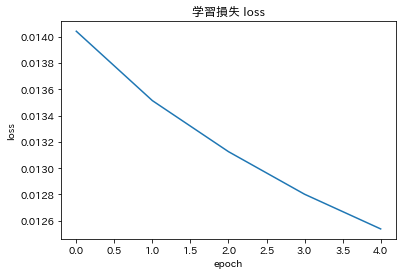

In [13]:
import matplotlib.pyplot as plt
import japanize_matplotlib
epoch_list = list(range(0, len(loss_list), 1)) #list(range(開始, 終了, 増分))
plt.plot(epoch_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("学習損失 loss")
plt.show()

# 8. アウトオブサンプル損失 outlossの可視化

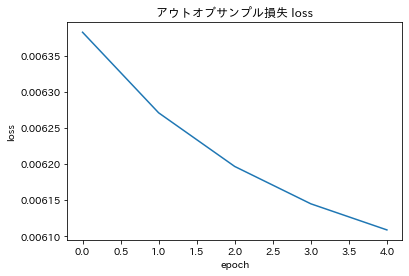

In [14]:
epoch_list_2 = list(range(0, len(outloss_list), 1)) #list(range(開始, 終了, 増分))
plt.plot(epoch_list_2, outloss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("アウトオブサンプル損失 loss")
plt.show()

# 9. 学習損失 lossとアウトオブサンプル損失 outlossの保存

In [15]:
epoch_list_2 = pd.Series(epoch_list, name = 'epoch')
loss_list_2 = pd.Series(loss_list, name = 'learning loss')
outloss_list_2 = pd.Series(outloss_list, name = 'outofsample loss')
Rtotal_list_2 = pd.Series(Rtotal_list, name = 'Rtotal')
Rpred_list_2 = pd.Series(Rpred_list, name = 'Rpred')
epoloss = pd.concat([epoch_list_2, loss_list_2, outloss_list_2, Rtotal_list_2, Rpred_list_2], axis = 1)
with pd.ExcelWriter('./epoch_loss(sample model)-2.xlsx') as writer: 
    epoloss.to_excel(writer)